* The clips can contain background music --> this could be a way of matching using a pretrained  music detection model
* The training data provides gender and age; could train a gender seperation model, or use a pretrained one as a starting point for accepting/rejecting
* The volume might be a way of pairing


In [1]:
# https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/data_preparation
# https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/pretrained/model
# http://pyannote.github.io/pyannote-core/
# https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/pretrained/model
# Needed pip install numba==0.48 and librosa==0.7.2

## https://github.com/pyannote/pyannote-audio/tree/develop/tutorials/models/speaker_embedding
# https://github.com/pyannote/pyannote-pipeline/blob/18e2c609d1fef4f01d1589231c5a1855fbb3ae5b/pyannote/pipeline/blocks/classification.py#L91

In [2]:
import torch
from pathlib import Path
import numpy as np
from tqdm import tqdm
# speaker embedding model trained on AMI training set
emb = torch.hub.load('pyannote/pyannote-audio', 'emb_ami')

Using cache found in /home/ben/.cache/torch/hub/pyannote_pyannote-audio_master


In [5]:
# one can use their own file like this...

test_file1 = {'uri': 'filename', 'audio': '/media/ben/datadrive/Zalo/voice-verification/Train-Test-Data/dataset/5-F-27/5-2.wav'}
test_file2 = {'uri': 'filename', 'audio': '/media/ben/datadrive/Zalo/voice-verification/Train-Test-Data/dataset/5-F-27/5.wav'}
test_file3 = {'uri': 'filename', 'audio': '/media/ben/datadrive/Zalo/voice-verification/Train-Test-Data/dataset/812-M-27/812.wav'}
test = [test_file1, test_file2]
amifile = {'uri': 'filename', 'audio': '/media/ben/datadrive/Software/pyannote-audio/data/ami/amicorpus/ES2003c/audio/ES2003c.Mix-Headset.wav'}
embeddings = emb(test_file1)
embeddings.data.shape

(1, 512)

In [6]:

chunks = embeddings.sliding_window
print(f'Embeddings were extracted every {1000 * chunks.step:g}ms on {1000 * chunks.duration:g}ms-long windows.')


Embeddings were extracted every 500ms on 2000ms-long windows.


In [7]:
 torch.cuda.current_device(), torch.cuda.is_available()

(0, True)

In [8]:

speaker_ids = []
uris = []
embeddings = []
root = Path("/media/ben/datadrive/Zalo/voice-verification/Train-Test-Data/dataset/")
j = 0
for i in tqdm(root.glob("**/**/*.wav")):
    speaker_id = str(i.parents[0].name)
    uri = str(speaker_id) + "_" + str(i.stem)
    embedding = emb({"uri": uri, "audio": str(i)})[0]
    speaker_ids.append(speaker_id)
    uris.append(uri)
    embeddings.append(embedding)
    j += 1
X = np.array(embeddings)
_, y_true = np.unique(speaker_ids, return_inverse=True)


10626it [18:51,  9.39it/s]


In [5]:
#with open('embeddings.npy', 'wb') as f:
#    np.save(f, X)
#with open('speaker_ids.npy', 'wb') as f:
#    np.save(f, speaker_ids)

X = np.load('embeddings.npy')
speaker_ids = np.load("speaker_ids.npy")
_, y_true = np.unique(speaker_ids, return_inverse=True)


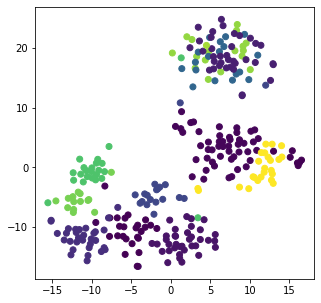

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
# apply tSNE on embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric="cosine")
X_2d = tsne.fit_transform(X[0:300])


# plot 
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
plt.scatter(*X_2d.T, c=y_true[0:300])

In [7]:
from pyannote.core.utils.distance import l2_normalize
from pyannote.core.utils.distance import cdist

In [73]:
X_target_norm = l2_normalize(X[0:1])
X_norm = l2_normalize(X)
distance = cdist(X_target_norm, X_norm, metric="cosine")
targets = np.argmin(distance, axis=0)
threshold = 0.1
#for i, k in enumerate(targets):
#    if distance[k, i] > self.threshold:
for i, k in enumerate(targets):
    # if distance[k, i] > threshold:
    print(f"k:{k} to {i}: distance: {distance[k, i]} label {y_true[i]} { {y_true[i] == y_true[k]}}")

k:0 to 0: distance: 0.0 label 307 {True}
k:0 to 1: distance: 0.38463571261086105 label 307 {True}
k:0 to 2: distance: 0.5343697248824404 label 307 {True}
k:0 to 3: distance: 0.36939959345351103 label 307 {True}
k:0 to 4: distance: 0.4242208382224605 label 307 {True}
k:0 to 5: distance: 0.4610890793830733 label 307 {True}
k:0 to 6: distance: 0.36963691779285424 label 307 {True}
k:0 to 7: distance: 0.6264389764043677 label 307 {True}
k:0 to 8: distance: 0.44261523247207857 label 307 {True}
k:0 to 9: distance: 0.43211498172827045 label 307 {True}
k:0 to 10: distance: 0.40209683577468336 label 307 {True}
k:0 to 11: distance: 0.5373604934636276 label 307 {True}
k:0 to 12: distance: 0.5008739237669022 label 307 {True}
k:0 to 13: distance: 0.6992699196637975 label 307 {True}
k:0 to 14: distance: 0.516828982542479 label 307 {True}
k:0 to 15: distance: 0.5101803888753169 label 307 {True}
k:0 to 16: distance: 0.5822133529558327 label 307 {True}
k:0 to 17: distance: 0.8115020012977054 label 264 {

k:0 to 2850: distance: 0.9493353905996313 label 250 {False}
k:0 to 2851: distance: 1.0216690784796716 label 250 {False}
k:0 to 2852: distance: 0.9498800232350824 label 250 {False}
k:0 to 2853: distance: 0.7922476728782334 label 250 {False}
k:0 to 2854: distance: 0.9221702030256993 label 250 {False}
k:0 to 2855: distance: 0.8770722137180684 label 250 {False}
k:0 to 2856: distance: 0.7018134938417506 label 354 {False}
k:0 to 2857: distance: 0.8586698506457415 label 354 {False}
k:0 to 2858: distance: 0.7118367046695437 label 354 {False}
k:0 to 2859: distance: 0.5241546664389916 label 354 {False}
k:0 to 2860: distance: 0.6893245790542302 label 354 {False}
k:0 to 2861: distance: 0.6988451630869043 label 354 {False}
k:0 to 2862: distance: 0.6944580772098546 label 354 {False}
k:0 to 2863: distance: 0.903237328867899 label 354 {False}
k:0 to 2864: distance: 0.8048629101475516 label 354 {False}
k:0 to 2865: distance: 0.818116875992043 label 354 {False}
k:0 to 2866: distance: 0.6761307627533797 

k:0 to 5763: distance: 0.9403549018140656 label 80 {False}
k:0 to 5764: distance: 1.0113968020821507 label 80 {False}
k:0 to 5765: distance: 0.9699944498253865 label 80 {False}
k:0 to 5766: distance: 0.9267841975789647 label 80 {False}
k:0 to 5767: distance: 0.9870078111971654 label 80 {False}
k:0 to 5768: distance: 1.0508741992517276 label 80 {False}
k:0 to 5769: distance: 0.9884163546351374 label 80 {False}
k:0 to 5770: distance: 0.9448387723821818 label 80 {False}
k:0 to 5771: distance: 1.0061984305342353 label 80 {False}
k:0 to 5772: distance: 0.8908214054413959 label 80 {False}
k:0 to 5773: distance: 0.8661949729910419 label 80 {False}
k:0 to 5774: distance: 0.9240269116221421 label 80 {False}
k:0 to 5775: distance: 0.928635969646453 label 80 {False}
k:0 to 5776: distance: 0.9106767028554192 label 80 {False}
k:0 to 5777: distance: 0.8166208565652645 label 92 {False}
k:0 to 5778: distance: 1.0982805816510162 label 92 {False}
k:0 to 5779: distance: 1.1551465114220139 label 92 {False

k:0 to 8791: distance: 0.8995455631737596 label 297 {False}
k:0 to 8792: distance: 0.8218305733397664 label 297 {False}
k:0 to 8793: distance: 0.7814077904897926 label 297 {False}
k:0 to 8794: distance: 0.8984294822009216 label 297 {False}
k:0 to 8795: distance: 1.0959016616583943 label 297 {False}
k:0 to 8796: distance: 0.9845375316408935 label 297 {False}
k:0 to 8797: distance: 0.9835157529324994 label 297 {False}
k:0 to 8798: distance: 0.9424034971328181 label 297 {False}
k:0 to 8799: distance: 0.9755324648187712 label 297 {False}
k:0 to 8800: distance: 0.4518366728687162 label 176 {False}
k:0 to 8801: distance: 0.3791136253408458 label 176 {False}
k:0 to 8802: distance: 0.5619648137388604 label 176 {False}
k:0 to 8803: distance: 0.7282267849816602 label 176 {False}
k:0 to 8804: distance: 0.4497544377691519 label 176 {False}
k:0 to 8805: distance: 0.38578233242230475 label 176 {False}
k:0 to 8806: distance: 0.3429445967500625 label 176 {False}
k:0 to 8807: distance: 0.57792307820903

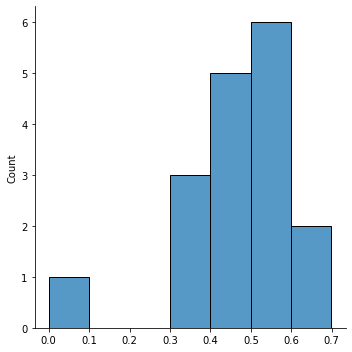

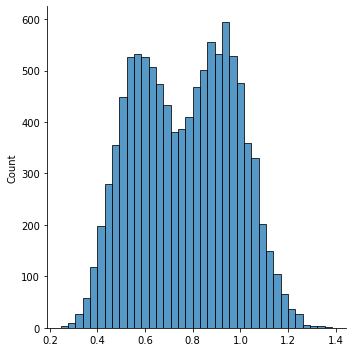

In [100]:
import seaborn as sns
# Taking the first item,  X[0:1]
target_index = 0
pred = distance[0,:]
Y = y_true == y_true[0] 

not_matching = pred[~Y]
matching = pred[Y]



sns.displot(matching)
sns.displot(not_matching)

In [99]:
# train a linear classifier to decide on the threshold

(1, 10626)

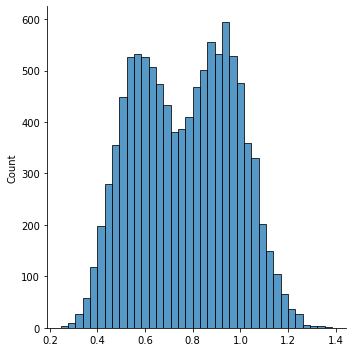